In [27]:
%load_ext autoreload
%autoreload 2

import sys
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# A fine-tuned model from betterModel.ipynb

model_name = "VGG16"
#model_name = "EfficientNetB0"
#model_name = "ResNet50"

model = load_model(f'/content/drive/MyDrive/CAFO_models/better{model_name}_step2.keras')

In [37]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

datasets = ["col", "ind", "jor", "kaz", "mys", "per", "per2", "tha", "tur",\
            "tur2", "ven", "sau"]

gdf_list = []
for place in datasets:
  gdf = pd.read_pickle(f'{data_path}{place}_final.pkl')
  print(f"There are {len(gdf)} rows in the {place} dataset")
  gdf_list.append(gdf)

data = pd.concat(gdf_list).reset_index(drop=True)

There are 213 rows in the col dataset
There are 143 rows in the ind dataset
There are 65 rows in the jor dataset
There are 64 rows in the kaz dataset
There are 196 rows in the mys dataset
There are 244 rows in the per dataset
There are 162 rows in the per2 dataset
There are 250 rows in the tha dataset
There are 107 rows in the tur dataset
There are 53 rows in the tur2 dataset
There are 255 rows in the ven dataset
There are 248 rows in the sau dataset


In [38]:
X = []
labels = []

for idx, row in data.iterrows():
  if row['Farm type'] == "Unknown CAFO":
    labels.append("CAFO")
    X.append(row["Sentinel"])
  elif row['Farm type'] == "Non-farm":
    labels.append("Non-farm")
    X.append(row["Sentinel"])
  else:
    print(f"Unexpected farm type, {row['Farm type']}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
y = to_categorical(encoded_labels, num_classes=len(set(labels)))

class_mapping = dict(zip(encoded_labels, labels))
print("Class mapping:", class_mapping)

meta = data.drop(columns=["Sentinel"])

Class mapping: {0: 'CAFO', 1: 'Non-farm'}


In [39]:
# Apply the model to all images
print(f"Applying the model to all {len(X)} images...")
results = utils.get_predictions(model, X, y, model_name, data)

Applying the model to all 2000 images...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step


In [40]:
colombia = results[results["Dataset name"] == "Colombia"]
india = results[results["Dataset name"] == "India"]
jordan = results[results["Dataset name"] == "Jordan"]
kazakhstan = results[results["Dataset name"] == "Kazakhstan"]
malaysia = results[results["Dataset name"] == "Malaysia"]
peru = results[results["Dataset name"] == "Peru"]
peru2 = results[results["Dataset name"] == "Peru2"]
saudi = results[results["Dataset name"] == "Saudi"]
turkey = results[results["Dataset name"] == "Turkey"]
turkey2 = results[results["Dataset name"] == "Turkey2"]
thailand = results[results["Dataset name"] == "Thailand"]
venezuela = results[results["Dataset name"] == "Venezuela"]

In [34]:
# Function for showing GradCAM heatmaps

def show_gradcam(df, prediction, label, layer, probability_range):
  X = [img['Sentinel'] for _, img in df.iterrows()]
  df.reset_index(inplace=True, drop=True)
  image, preprocessed_image = utils.select_test_image(X, model_name,\
                                                    df, prediction,\
                                                    label, probability_range)
  heatmap = utils.get_gradcam_heatmap(model, preprocessed_image,\
                                    last_conv_layer_name, prediction)
  utils.display_gradcam(image, heatmap, alpha=0.5)

# Colombia


In [9]:
print('\n', classification_report(colombia["Label"].to_list(), colombia['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.97      0.40      0.56       172
           1       0.27      0.95      0.42        41

    accuracy                           0.50       213
   macro avg       0.62      0.67      0.49       213
weighted avg       0.84      0.50      0.54       213



In [10]:
utils.plot_classified_images(X, colombia, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

/content/drive/MyDrive/Colab Notebooks/utils.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_0'] = df['Model Probabilities'].apply(lambda x: x[0])
/content/drive/MyDrive/Colab Notebooks/utils.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_1'] = df['Model Probabilities'].apply(lambda x: x[1])


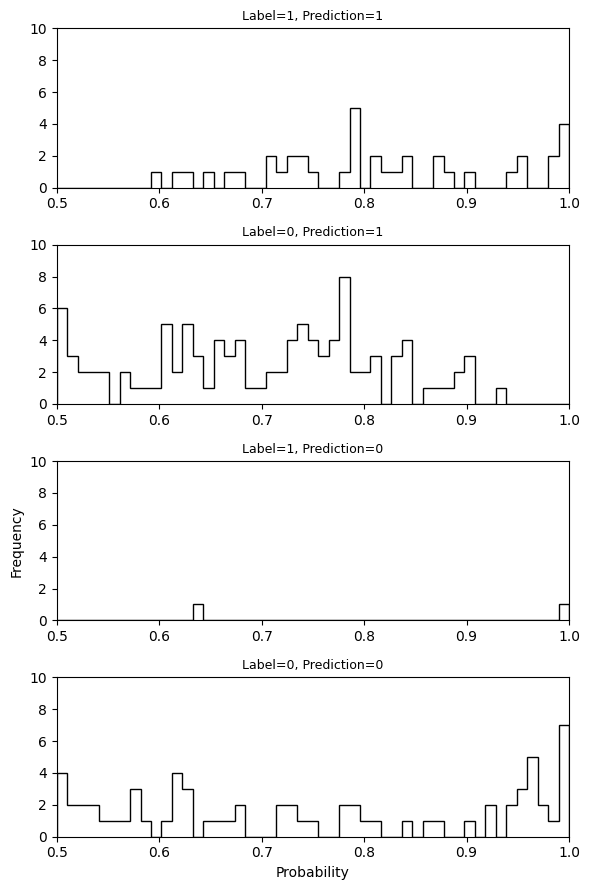

In [11]:
utils.probability_hist(colombia, datasets=["Colombia"], ymax=10)

# India

In [12]:
print('\n', classification_report(india["Label"].to_list(), india['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.88      0.63      0.74        84
           1       0.63      0.88      0.73        59

    accuracy                           0.73       143
   macro avg       0.75      0.76      0.73       143
weighted avg       0.78      0.73      0.73       143



In [13]:
utils.plot_classified_images(X, india, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

/content/drive/MyDrive/Colab Notebooks/utils.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_0'] = df['Model Probabilities'].apply(lambda x: x[0])
/content/drive/MyDrive/Colab Notebooks/utils.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_1'] = df['Model Probabilities'].apply(lambda x: x[1])


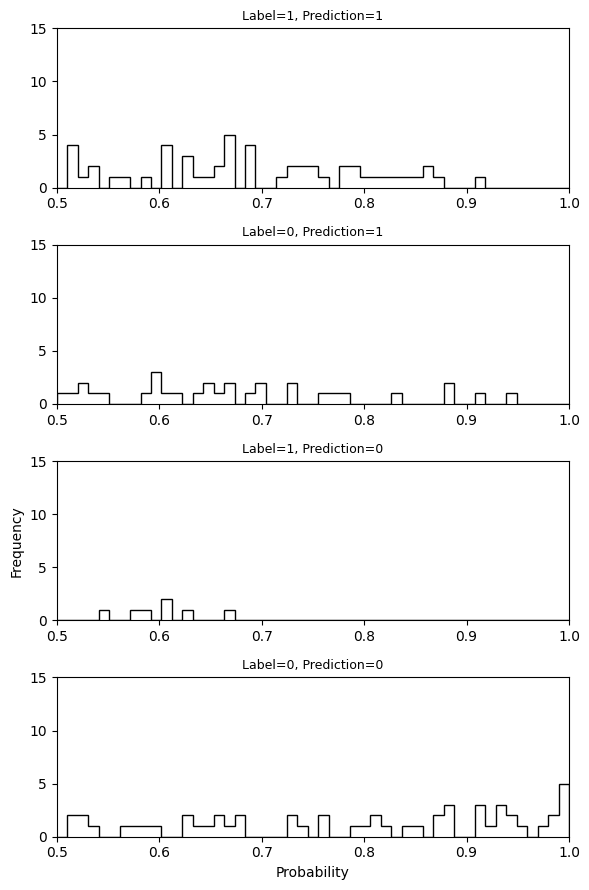

In [14]:
utils.probability_hist(india, datasets=["India"], ymax=15)

# Jordan

In [15]:
print('\n', classification_report(jordan["Label"].to_list(), jordan['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.36      0.59      0.44        17
           1       0.81      0.62      0.71        48

    accuracy                           0.62        65
   macro avg       0.58      0.61      0.58        65
weighted avg       0.69      0.62      0.64        65



In [16]:
utils.plot_classified_images(X, jordan, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

/content/drive/MyDrive/Colab Notebooks/utils.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_0'] = df['Model Probabilities'].apply(lambda x: x[0])
/content/drive/MyDrive/Colab Notebooks/utils.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_1'] = df['Model Probabilities'].apply(lambda x: x[1])


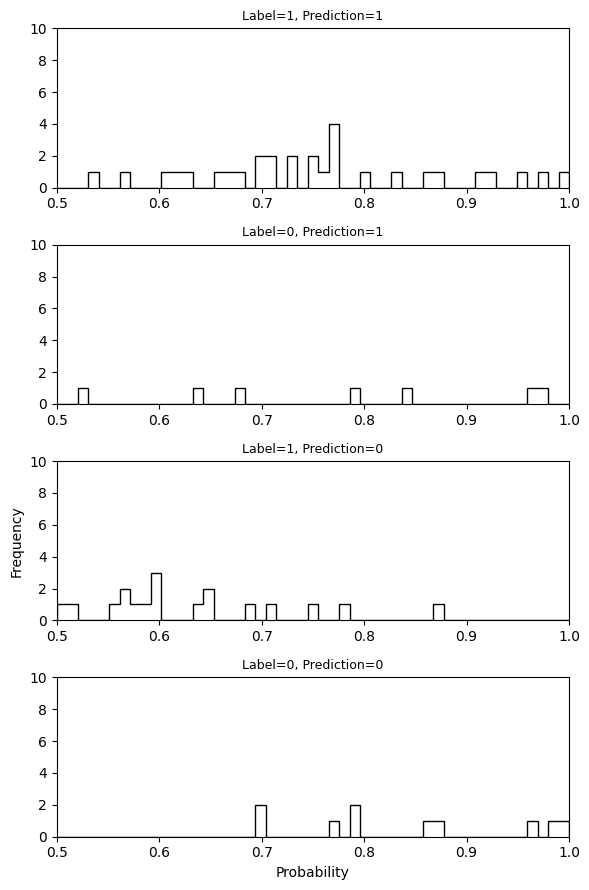

In [17]:
utils.probability_hist(jordan, datasets=["Jordan"], ymax=10)

# Kazakhstan

In [18]:
print('\n', classification_report(kazakhstan["Label"].to_list(), kazakhstan['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.94      0.53      0.68        32
           1       0.67      0.97      0.79        32

    accuracy                           0.75        64
   macro avg       0.81      0.75      0.74        64
weighted avg       0.81      0.75      0.74        64



In [19]:
utils.plot_classified_images(X, kazakhstan, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

/content/drive/MyDrive/Colab Notebooks/utils.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_0'] = df['Model Probabilities'].apply(lambda x: x[0])
/content/drive/MyDrive/Colab Notebooks/utils.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_1'] = df['Model Probabilities'].apply(lambda x: x[1])


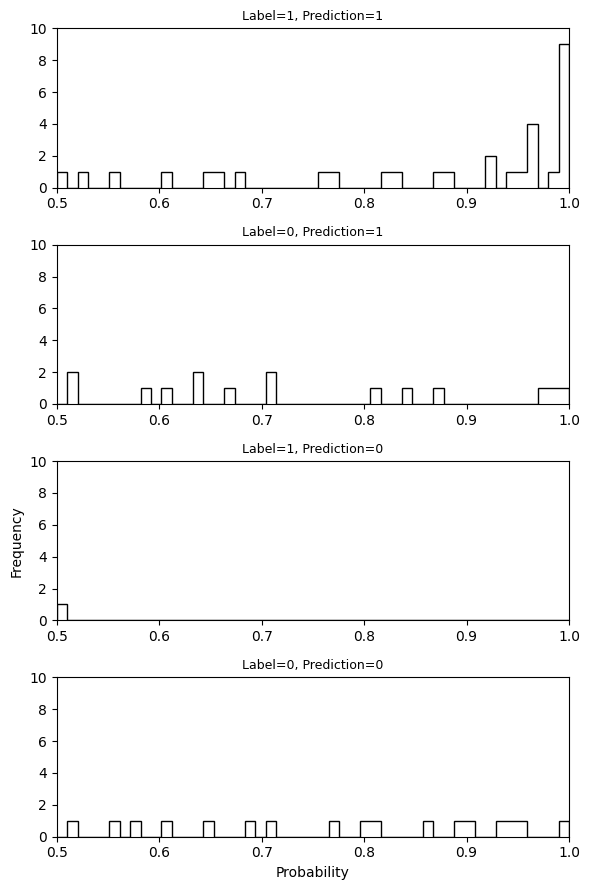

In [20]:
utils.probability_hist(kazakhstan, datasets=["Kazakhstan"], ymax=10)

# Malaysia

In [21]:
print('\n', classification_report(malaysia["Label"].to_list(), malaysia['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.74      0.78      0.76        45
           1       0.93      0.92      0.93       151

    accuracy                           0.89       196
   macro avg       0.84      0.85      0.84       196
weighted avg       0.89      0.89      0.89       196



In [22]:
utils.plot_classified_images(X, malaysia, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

# Peru - Alto Laran

In [23]:
print('\n', classification_report(peru["Label"].to_list(), peru['Model Class'].to_list()))


               precision    recall  f1-score   support

           0       0.93      0.44      0.59       386
           1       0.29      0.88      0.44       102

    accuracy                           0.53       488
   macro avg       0.61      0.66      0.52       488
weighted avg       0.80      0.53      0.56       488



In [24]:
utils.plot_classified_images(X, peru, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

/content/drive/MyDrive/Colab Notebooks/utils.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_0'] = df['Model Probabilities'].apply(lambda x: x[0])
/content/drive/MyDrive/Colab Notebooks/utils.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Probability_1'] = df['Model Probabilities'].apply(lambda x: x[1])


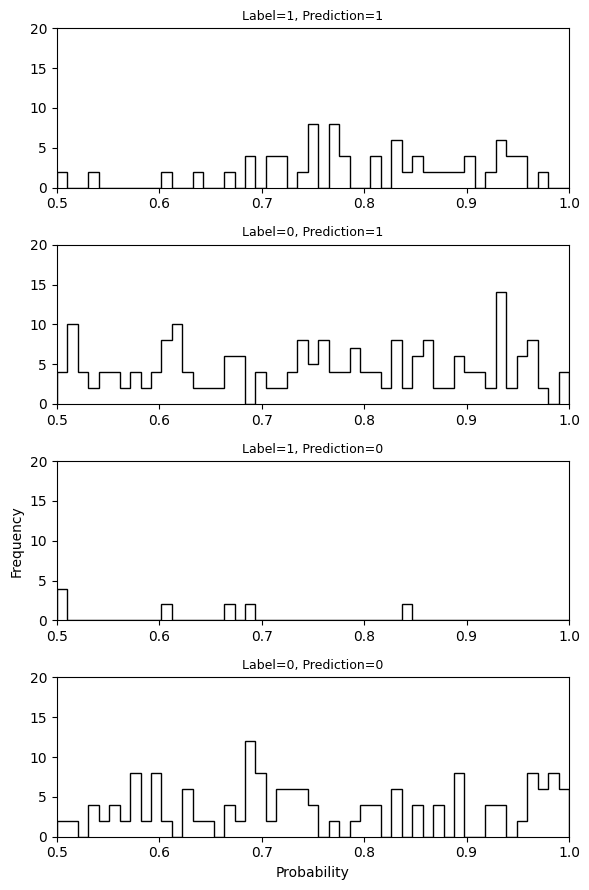

In [25]:
utils.probability_hist(peru, datasets=["Peru"], ymax=20)

# Peru - Punta Hermosa

In [42]:
print('\n', classification_report(peru2["Label"].to_list(), peru2['Model Class'].to_list()))

,Label,Model Probabilities,Model Class,Dataset name,Farm type,geometry,Sentinel
925,1,"[0.13532871, 0.86467135]",1,Peru2,Non-farm,POINT (-76.84193 -12.2952),"[[[142.94208240237904, 126.22486611113202, 107..."
926,1,"[0.17815737, 0.82184255]",1,Peru2,Non-farm,POINT (-76.84526 -12.28361),"[[[126.74468997785597, 108.79667399695228, 86...."
927,1,"[0.48662496, 0.51337504]",1,Peru2,Non-farm,POINT (-76.84517 -12.26537),"[[[159.54903539337587, 135.50444482077236, 102..."
928,1,"[0.04998205, 0.9500179]",1,Peru2,Non-farm,POINT (-76.84005 -12.3084),"[[[182.0033864960868, 163.4211210541999, 135.3..."
929,1,"[0.11375461, 0.8862454]",1,Peru2,Non-farm,POINT (-76.84041 -12.30678),"[[[137.35204238115813, 115.48597132702567, 88...."
...,...,...,...,...,...,...,...
1082,1,"[0.13599011, 0.86400986]",1,Peru2,Non-farm,POINT (-76.7097 -12.39266),"[[[159.60886339380536, 145.6339971188984, 128...."
1083,1,"[0.35838613, 0.6416139]",1,Peru2,Non-farm,POINT (-76.67844 -12.38673),"[[[141.30762016721624, 126.5221888928945, 111...."
1084,0,"[0.510341, 0.48965898]",0,Peru2,Unknown CAFO,POINT (-76.7203 -12.37551),"[[[106.00812025936492, 88.66945641206522, 72.0..."
1085,0,"[0.9354005, 0.06459952]",0,Peru2,Unknown CAFO,POINT (-76.71132 -12.37003),"[[[67.25206346855505, 59.76135242555905, 52.41..."



               precision    recall  f1-score   support

           0       0.57      0.71      0.63        17
           1       0.96      0.94      0.95       145

    accuracy                           0.91       162
   macro avg       0.77      0.82      0.79       162
weighted avg       0.92      0.91      0.92       162



In [43]:
utils.plot_classified_images(X, peru2, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

# Saudi Arabia

In [ ]:
print('\n', classification_report(saudi["Label"].to_list(), saudi['Model Class'].to_list()))

In [ ]:
utils.plot_classified_images(X, saudi, class_mapping, ascending=False)

In [ ]:
utils.probability_hist(saudi, datasets=["Saudi"], ymax=20)

# Thailand

In [ ]:
print('\n', classification_report(thailand["Label"].to_list(), thailand['Model Class'].to_list()))

In [ ]:
utils.plot_classified_images(X, thailand, class_mapping, ascending=False)

In [ ]:
utils.probability_hist(thailand, datasets=["Thailand"], ymax=10)

# Turkey - Afyonkarahisar

In [ ]:
print('\n', classification_report(turkey["Label"].to_list(), turkey['Model Class'].to_list()))

In [ ]:
utils.plot_classified_images(X, turkey, class_mapping, ascending=False)

In [ ]:
utils.probability_hist(turkey, datasets=["Turkey"], ymax=10)

# Turkey2 - Basmakci

In [ ]:
print('\n', classification_report(turkey2["Label"].to_list(), turkey2['Model Class'].to_list()))

In [ ]:
utils.plot_classified_images(X, turkey2, class_mapping, ascending=False)

In [ ]:
# Display GradCAM heatmaps

prediction = 0
label = 1
probability_range = (0.5, 1.0)
last_conv_layer_name = 'block4_conv3'

show_gradcam(turkey, prediction, label, last_conv_layer_name, probability_range)

# Venezuela

In [ ]:
print('\n', classification_report(venezuela["Label"].to_list(), venezuela['Model Class'].to_list()))

In [ ]:
utils.plot_classified_images(X, venezuela, class_mapping, ascending=False)

In [ ]:
utils.probability_hist(venezuela, datasets=["Venezuela"], ymax=20)